### 3-layer MacArthur consumer-resource model
Zhijie Feng & Maria Yampolskaya

In [1]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import cvxpy as cvx

We want to simulate the MacArthur Consumer-Resource Model for three layers:
\begin{align*}
    \frac{dX_A}{dt} &= X_A (\sum_a d_{Aa} N_a - u_A) \\
    \frac{dN_a}{dt} &= N_a (\sum_{\alpha} c_{a \alpha} R_{\alpha} - m_a - \sum_A X_A d_{Aa}) \\
    \frac{dR_{\alpha}}{dt} &= R_{\alpha}( k_{\alpha} - R_{\alpha} - \sum_a c_{a \alpha} N_a)
\end{align*}

In [2]:
def consumer_resource(t, state):
        X = state[:top_species]
        N = state[top_species:top_species+middle_species]
        R = state[top_species+middle_species:]
        
        dX = X*(np.dot(D,N)-u)
        dN = N*(np.dot(C,R)-m-np.dot(D.T,X))
        dR = R*(k-R-np.dot(C.T,N))
        
        return np.concatenate((dX,dN,dR),axis=None)

In [3]:
# Set the number of species/variants in each layer
top_species = 10
middle_species = 30
resources = 100

# Set the statistics for the consumer-preference matrices
D_mean = 1
D_std_dev = 1

C_mean = 1
C_std_dev = 1

# Create the matrices and vectors featured in the differential equations

D = D_mean/middle_species + D_std_dev*np.random.normal(0, 1, (top_species,middle_species))/np.sqrt(middle_species)
C = C_mean/resources+C_std_dev*np.random.normal(0, 1, (middle_species,resources))/np.sqrt(resources)

u = np.random.uniform(0.5,1.5,top_species)
m = np.random.uniform(0.5,1.5,middle_species)
k = np.random.uniform(0.5,1.5,resources)

# This vector contains the information about X, N, and R by creating a long vector:
# (X, N, R)
initial_state = np.random.uniform(0,1,top_species+middle_species+resources)
# initial_state = np.ones(top_species+middle_species+resources)

In [4]:
sol = solve_ivp(consumer_resource, t_span=[0,200], y0=initial_state.copy(), dense_output=True)

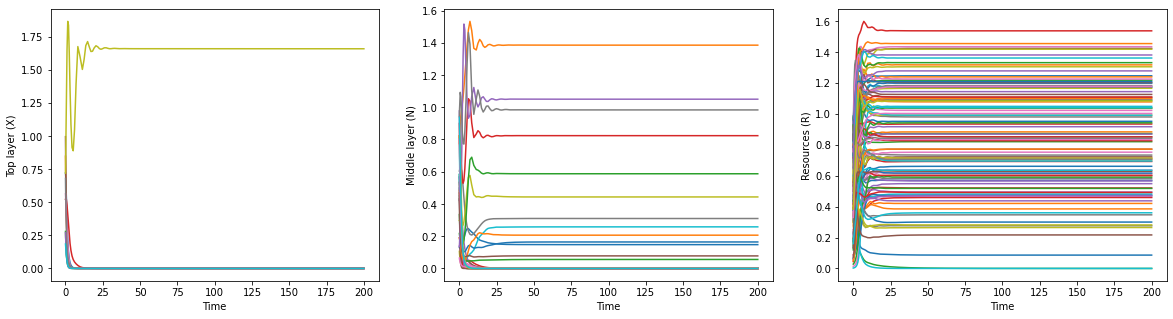

In [5]:
fig, axs = plt.subplots(1,3, figsize=(20, 5))

axs[0].plot(sol.t, sol.y[:top_species].T)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Top layer (X)')

axs[1].plot(sol.t, sol.y[top_species:top_species+middle_species].T)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Middle layer (N)')

axs[2].plot(sol.t, sol.y[top_species+middle_species:].T)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Resources (R)')

plt.show()

The steady-state solution to the differential equations is equivalent to this optimization problem:

\begin{align*}
\min_N (-\sum_{i\beta} N_i &(c_{i\beta}K_\beta-m_i)+\frac{1}{2}\sum_{ij}\phi_{ij} N_jN_i) \\
\phi_{ij}&=\sum_{ \beta}c_{i\beta} c_{j\beta} 
\end{align*}

subject to
\begin{align*}
\sum_i d_{ai}N_i &\leq u_a \\
N_i&\geq0
\end{align*}


In [6]:
N_opt = cvx.Variable(middle_species)
constraints=[D @ N_opt <= u, N_opt >= 0]

prob = cvx.Problem(cvx.Minimize(-N_opt@(np.dot(C,k).T - m) + 0.5*cvx.quad_form(N_opt, np.dot(C,C.T)) ), constraints)
prob_output = prob.solve()

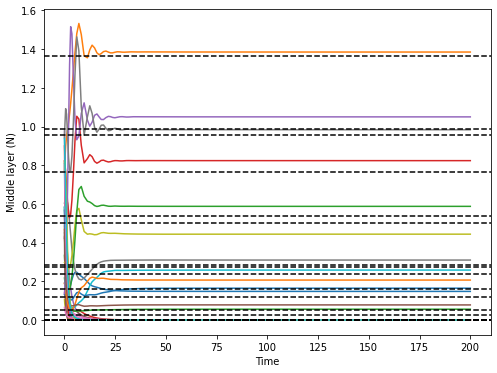

In [7]:
plt.figure(figsize=(8,6))
plt.plot(sol.t, sol.y[top_species:top_species+middle_species].T)
plt.xlabel('Time')
plt.ylabel('Middle layer (N)')

for value in N_opt.value:
       plt.axhline(value,color='k',ls='--')
        
plt.show()

# For the next few sections, we only take the rows and columns corresponding to surviving species and resources

In [8]:
survival_boolean = sol.y[:,-1] > 1e-3

In [9]:
top_survived = survival_boolean[:top_species]
middle_survived = survival_boolean[top_species:top_species+middle_species]
resources_survived = survival_boolean[top_species+middle_species:]

initial_state = initial_state[survival_boolean]
C = C[middle_survived,:][:,resources_survived]
D = D[top_survived,:][:,middle_survived]

u = u[top_survived]
m = m[middle_survived]
k = k[resources_survived]

Let's test if the following Lotka-Volterra equation correctly replicates the top layer steady state:
\begin{align*}
    \frac{dX_A}{dt} &= X_A ( (D(CC^T)^{+}(Ck - m - X D^T))_A - u_A ) \\
    &= X_A (\kappa_A - \sum_a \Gamma_{Aa} X_{a} )
\end{align*}

In [10]:
def lotka_volterra(t, X):
    Gamma = D@np.linalg.pinv(np.dot(C,C.T))@D.T
    Gamma_star = D@np.linalg.inv(np.dot(C,C.T))
    kappa = Gamma_star@np.dot(C,k) - Gamma_star@m - u
    
    return X*(kappa - Gamma@X)

In [11]:
sol_LV = solve_ivp(lotka_volterra, t_span=[0,200], y0=initial_state[np.where(top_survived)].copy(), dense_output=True)

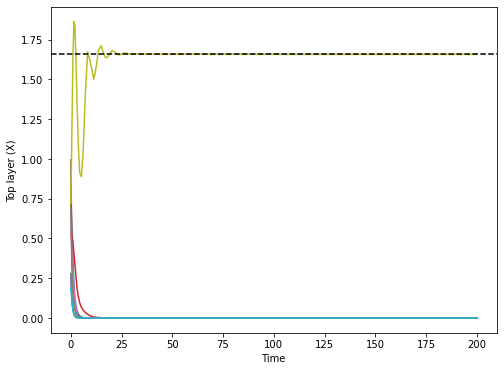

In [12]:
plt.figure(figsize=(8,6))
plt.plot(sol.t, sol.y[:top_species].T)
# plt.plot(sol_LV.t, sol_LV.y.T)
plt.xlabel('Time')
plt.ylabel('Top layer (X)')

for value in sol_LV.y.T[-1]:
       plt.axhline(value,color='k',ls='--')
        
plt.show()

Let's test the following result from finding the block-inverse (note: only the rows and columns relevant to the surviving species are involved):
\begin{align*}
    \begin{pmatrix}
    I - C^T (CC^T)^{-1} C + C^T \beta \gamma \alpha C & C^T (CC^T)^{-1} - C^T \beta \gamma \alpha & -C^T \beta \gamma \\
    (CC^T)^{-1} C -\beta \gamma \alpha C & -(CC^T)^{-1} + \beta \gamma \alpha & \beta \gamma \\
    \gamma \alpha C & -\gamma \alpha & -\gamma
    \end{pmatrix}
    \begin{pmatrix}
    k \\
    m \\
    u
    \end{pmatrix}
    &=
    \begin{pmatrix}
    R \\
    N \\
    X
    \end{pmatrix}
\end{align*}

$\alpha, \beta, \gamma$ are defined as follows:
\begin{align*}
    \gamma &= (D (CC^T)^{-1} D^T)^{-1} = -S^{-1} \\
    \alpha &= D(CC^T)^{-1} \\
    \beta &= (CC^T)^{-1}D^T
\end{align*}

In [13]:
A = C@C.T
A_inv = np.linalg.inv(A)
gamma = np.linalg.inv(D@A_inv@D.T)
alpha = D@A_inv
beta = A_inv@D.T

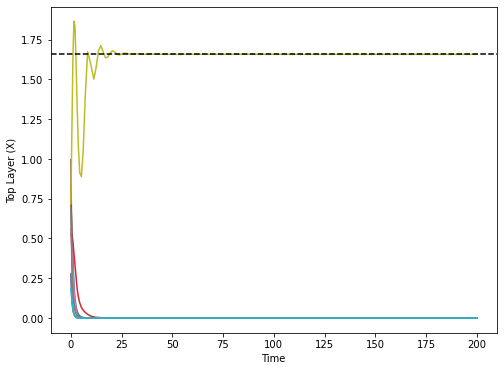

In [14]:
X_star = gamma@alpha@C@k - gamma@alpha@m - gamma@u

plt.figure(figsize=(8,6))
plt.plot(sol.t, sol.y[:top_species].T)
plt.xlabel('Time')
plt.ylabel('Top Layer (X)')
for value in X_star:
       plt.axhline(value,color='k',ls='--')

plt.show()

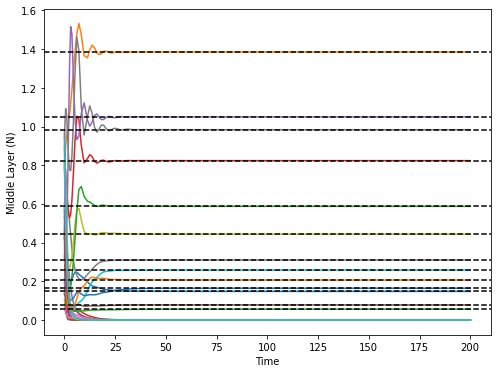

In [15]:
N_star = (A_inv@C - beta@gamma@alpha@C)@k + (-A_inv + beta@gamma@alpha)@m + beta@gamma@u

plt.figure(figsize=(8,6))
plt.plot(sol.t, sol.y[top_species:top_species+middle_species].T)
plt.xlabel('Time')
plt.ylabel('Middle Layer (N)')
for value in N_star:
       plt.axhline(value,color='k',ls='--')

plt.show()

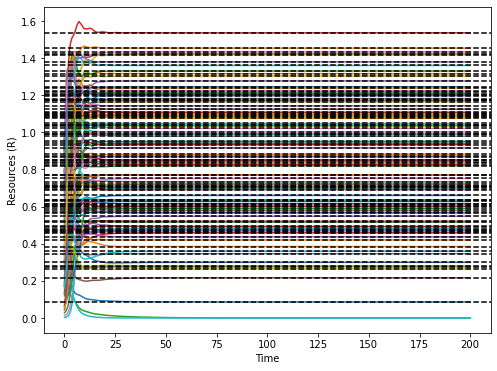

In [16]:
R_star = (np.identity(len(k)) - C.T@A_inv@C + C.T@beta@gamma@alpha@C)@k + (C.T@A_inv - C.T@beta@gamma@alpha)@m - (C.T@beta@gamma)@u

plt.figure(figsize=(8,6))
plt.plot(sol.t, sol.y[top_species+middle_species:].T)
plt.xlabel('Time')
plt.ylabel('Resources (R)')
for value in R_star:
       plt.axhline(value,color='k',ls='--')

plt.show()